In [1]:
import torchaudio

wav,sr = torchaudio.load("LJSpeech-1.1/wavs/LJ001-0001.wav")
#here wav is the actual audio file and sr is the sampling rate
# In pytorch audio tensors are always formatted as [channels, time]. time is represented as the no of samples not in seconds.
print(wav.shape,sr)

torch.Size([1, 212893]) 22050


c:\Users\vinay\anaconda3\envs\speechbrainDemo\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [2]:
# the sampling rate the speechbrain expects is 16000 but our audio has sr of 22050 so we need to resample the audio
'''Neural models are sampling-rate dependent.
   Wrong SR = wrong frequency interpretation = broken embeddings.
'''

resampler = torchaudio.transforms.Resample(
    orig_freq=22050,
    new_freq=16000
)

wav = resampler(wav)
sr = 16000
print(wav.shape, sr)

torch.Size([1, 154481]) 16000


In this example we are going to use a pre-trained ECAPA model.  
- ECAPA models do not take raw waveform as input
- It takes Log-Mel Filterbank(FBank) features

Now we will extract the FBank features

In [3]:
import matplotlib.pyplot as plt
from speechbrain.processing.features import Filterbank, STFT

# applying short time fast Fourier Transform to the raw audio file
# The output is a bunch of compllex numbers
stft = STFT(sample_rate=16000)
features = stft(wav)

# we convert the complex numbers to their magnitude. This gives us the power spectrum.
power_spec = (features ** 2).sum(dim=-1)

c:\Users\vinay\anaconda3\envs\speechbrainDemo\Lib\site-packages\speechbrain\utils\torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()


In [4]:
# Now we give this power spectrogram as input to the mel Filterbank, which gives us the mel-spectrum
Fbank = Filterbank(
    sample_rate=16000,
    n_mels=80
)

mel_spec = Fbank(power_spec)
print(mel_spec.shape)

torch.Size([1, 966, 80])


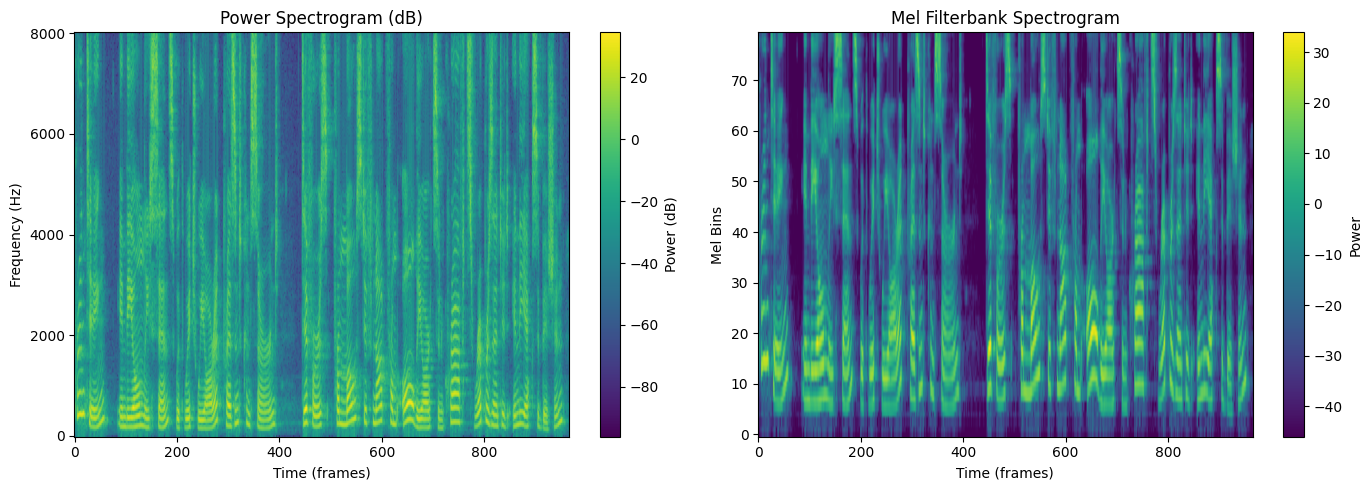

In [5]:
import torch
import matplotlib.pyplot as plt

# Assuming you have:
# - power_spec: shape (batch, time_frames, freq_bins) - raw power values
# - mel_spec: shape (batch, time_frames, mel_bins) - mel filterbank output
# - sample_rate: your audio sample rate (e.g., 16000 Hz)

sample_rate = 16000  # Hz

# ============================================================================
# STEP 1: Convert power spectrogram to decibel (dB) scale
# ============================================================================
# Why: Audio power has huge dynamic range (can span 9+ orders of magnitude)
# Without log scale, quiet sounds are invisible and visualization is useless
# dB formula: 10 * log10(power)
# Add small epsilon (1e-10) to avoid log(0) which would be -infinity

power_spec_db = 10 * torch.log10(power_spec + 1e-10)

# ============================================================================
# STEP 2: Create side-by-side subplot figure
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ============================================================================
# STEP 3: Plot Power Spectrogram (in dB)
# ============================================================================
# imshow parameters:
# - .T transposes to put frequency on y-axis, time on x-axis
# - aspect='auto': automatically adjusts aspect ratio to fill the plot
# - origin='lower': puts low frequencies at bottom (more intuitive)
# - cmap='viridis': perceptually uniform colormap (good for scientific data)

im1 = axes[0].imshow(
    power_spec_db[0].T.cpu().numpy(),  # [0] takes first item in batch
    aspect='auto', 
    origin='lower',
    cmap='viridis'
)

axes[0].set_title('Power Spectrogram (dB)')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Frequency (Hz)')

# ============================================================================
# STEP 4: Add correct frequency labels for y-axis
# ============================================================================
# The FFT produces frequency bins from 0 Hz to Nyquist frequency
# Nyquist frequency = sample_rate / 2 (maximum representable frequency)
# For 16 kHz audio: Nyquist = 8000 Hz

n_freq_bins = power_spec.shape[2]  # Number of frequency bins in spectrogram
nyquist_freq = sample_rate / 2      # Maximum frequency (Hz)

# Set tick positions at 0%, 25%, 50%, 75%, and 100% of frequency range
# Note: Use n_freq_bins-1 for the last tick (0-indexed)
tick_positions = [0, n_freq_bins//4, n_freq_bins//2, 3*n_freq_bins//4, n_freq_bins-1]
axes[0].set_yticks(tick_positions)

# Calculate corresponding frequency values for each tick
# Frequency of bin i = (i / n_freq_bins) * nyquist_freq
tick_labels = [
    '0',
    f'{int(nyquist_freq/4)}',
    f'{int(nyquist_freq/2)}',
    f'{int(3*nyquist_freq/4)}',
    f'{int(nyquist_freq)}'
]
axes[0].set_yticklabels(tick_labels)

# Add colorbar to show power scale in dB
plt.colorbar(im1, ax=axes[0], label='Power (dB)')

# ============================================================================
# STEP 5: Plot Mel Filterbank Spectrogram
# ============================================================================
# Mel scale: perceptual frequency scale that mimics human hearing
# Lower mel bins = lower frequencies (more bins per Hz)
# Higher mel bins = higher frequencies (fewer bins per Hz)

im2 = axes[1].imshow(
    mel_spec[0].T.cpu().numpy(), 
    aspect='auto', 
    origin='lower',
    cmap='viridis'
)

axes[1].set_title('Mel Filterbank Spectrogram')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Mel Bins')

# Note: Y-axis shows mel bin indices, not frequencies
# Mel bins are non-linearly spaced in frequency
# Lower mel bins cover narrow frequency ranges (more resolution at low freq)
# Higher mel bins cover wide frequency ranges (less resolution at high freq)

# Add colorbar to show power scale (linear or dB depending on mel_spec)
plt.colorbar(im2, ax=axes[1], label='Power')

# ============================================================================
# STEP 6: Display the plots
# ============================================================================
plt.tight_layout()  # Adjusts spacing to prevent label overlap
plt.show()

1. Power Spectrogram (Left)
    - What it is: A standard visualization of the signal's power across a linear frequency scale (0 to 8,000 Hz).
    - Key Detail: It shows the raw frequency components. You can clearly see the horizontal bands at the bottom, which represent the fundamental frequency and harmonics of a voice.
    - Scale: The frequency (Y-axis) increases linearly, meaning the distance between 1000Hz and 2000Hz is the same as the distance between 7000Hz and 8000Hz.

2. Mel Filterbank Spectrogram (Right)
    - What it is: A spectrogram where the frequency has been converted to the Mel Scale.
    - Key Detail: The Mel scale is a non-linear transformation designed to mimic human hearing. Humans are much better at detecting small changes in pitch at lower frequencies than at higher ones.
    - Result: Notice how the lower frequency area (the "Mel Bins" 0–40) appears "zoomed in" or more detailed compared to the linear plot. This effectively compresses the higher frequencies and emphasizes the parts of the sound that are most relevant to human perception and speech recognition.



## Loading and using a pre-trained ECAPA model

Encoderclassifier is a pipeline which takes in raw audio and embeds it directly into vectors so we need not worry about handcrafting features.  
Just for the sake of understanding I have performed the above steps.

In [6]:
from speechbrain.inference.classifiers import EncoderClassifier

model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device":"cuda"}
)

c:\Users\vinay\anaconda3\envs\speechbrainDemo\Lib\site-packages\speechbrain\utils\torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
c:\Users\vinay\anaconda3\envs\speechbrainDemo\Lib\site-packages\speechbrain\utils\autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


In [7]:
embedding = model.encode_batch(wav)
print(embedding.shape)

torch.Size([1, 1, 192])


In [8]:
embedding = embedding.squeeze()
print(embedding.shape)

torch.Size([192])
